# 1D CODE

In [1]:
import numpy as np
import matplotlib
import math
import time
import pickle


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import itertools


import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import tensorflow_probability as tfp


%matplotlib inline

## Run auxiliary functions:

In [2]:
%run ./auxiliary_func_noprint.ipynb

## Choose input/output dimensions and look at the examples

In [3]:
## Allowed input/output values in this preliminary version are (ni=2 no=1) (ni=3 no=1) (ni=3 no=2) and (ni=1 no=1) 

ni=1 #number of input variables  
no=1 #number of output solutions 

#LOOK AT THE PDE DICTIONARIES MATCHING THE DIMENSION REQUIREMENTS
#################################################################################
### outputfunction is named u, v
### first derivatives are named dudt, dudx, dudy
### pure second derivatives are named dduddt, dduddx, dduddy
### mixed second derivative (as ddudtdx) need to be coded in the loss function, we will provide an automatic derivation in future updates.
############## NOTATION #####################
## eomdict: impose PDE constraints. The form needs to be '[ eq1 , eq2 ]' 
## ICdict: Boundary conditions on t belonging to [t0,tL].
##         The form needs to be [ '[ u - u(t0,x,y),dudt - dudt(t0,x,y)]' , '[u - u(tL,x,y),dudt - dudt(tL,x,y)]' ] 
##         If no condition needs to be provided on some boundary just replace (u - u(t,x,y0) ) with  [none].
## boardx: Boundary conditions on x belonging to [x0,xL].
##         The form needs to be [ '[u - u(t,x0,y),dudx - dudx(t,x0,y)]' , '[u - u(t,xL,y),dudx - dudx(t,xL,y)]' ]   
##         If no condition needs to be provided on some boundary just replace (u - u(t,x,y0) ) with  [none].
## boardy: Boundary conditions in y belonging to [y0,yL].
##         The form needs to be [ '[u - u(t,x,y0),dudy - dudy(t,x,y0)]' , '[u - u(t,x,yL),dudy - dudy(t,x,yL)]' ] 
##         If no condition needs to be provided on some boundary just write  [none].
## wdict:  weights to be used in loss function
##         The form needs to be [w_bulk,w_IC,w_board]

eqname_dict=eqname_gen(ni,no)
analytic=eqname_analytic(ni,no)
sol=sol_analytic(ni,no)

if ni==1:
    eomdict,ICdict=dictgen(ni,no)
elif ni==2:
    eomdict,ICdict,boardx,wdict=dictgen(ni,no)
elif ni==3:
    eomdict,ICdict,boardx,boardy,wdict=dictgen(ni,no)

eomdict


{'oscillon': '[dduddt-0.5**2*u+2.*u**3.]',
 'mat': '[dduddt+(1.-0.4*tf.cos(2.*t))*u]',
 'exp': '[dudt+0.5*u]',
 'wave': '[dduddt+25.*u]',
 'dho': '[dduddt+0.5*dudt+25.*u]',
 'linear': '[dudt-1.]',
 'delay': '[dudt-0.5*u+1.*du]',
 'gaussian': '[dudt+0.2*t*u]',
 'stiff': '[dudt+21.*u-tf.exp(-t)]',
 'twofreq': '[dduddt+u+2.*tf.cos(5.*t)+6.*tf.sin(10.*t)]'}

In [4]:
#####################################################
#### Choose the equation of motion to be studied
#####################################################
### 3to1 D equations studied: ['waveb','wave','wavet', 'poisson1', 'poisson2', 'poisson3','heat1','heat2']
### 3to2 D equations studied: ['GT','LO','NS']
### 2to1 D equations studied: [{'wave','waveN','twave','heat','heat2f','heat0','poisson','poisson1','AdvectionDiffusion','Burgers','poisson_par','par']
### 1to1 D equations studied: [{'oscillon', 'mat', 'exp', 'wave', 'dho', 'linear', 'delay', 'gaussian', 'stiff', 'twofreq'}]
#####
##Create the list of coordinate boundaries, i.e. boundaries=[t_0,t_max,x_0,x_max,y_0,y_max]
#### Boudaries used in the paper
#bd=[0.,1.,0.,1.,0.,1.]               # 3to1 D
#bd=[0.,1.,0.,2.*np.pi,0.,2.*np.pi]   #'GT'
#bd=[0.1,1.,-2.,2.,-2.,2.]            #'LO'
#bd=[0.,10.,0.,1.,0.,1.]              #'NS'
#bd=[0.,1.,0.,1.]                     # 2to1 D
#bd=[0.,20.]                          # 1to1 D

bd=[0.,20.]



## define number of points to be sampled in the bulk, the IC and on each boundary surface
n_bulk=2048
batch_sz=512


##Initialise the 2 networks
n_l=35 #number of neurons per branch

#create base frequencies to initialize the network
pi=tf.constant(np.pi,dtype=tf.float32)
none=tf.constant(0.,dtype=tf.float32)
freq_t=base_freq(ni,bd)
step=2.

model=dNNsolve(ni,no,n_l,bd,step)

model.save_weights(f"model_seq_{ni}D_{n_l}nodes.h5")


n_l=5 #number of neurons per branch

#create base frequencies to initialize the network
pi=tf.constant(np.pi,dtype=tf.float32)
none=tf.constant(0.,dtype=tf.float32)
freq_t=base_freq(ni,bd)
step=2.

model=dNNsolve(ni,no,n_l,bd,step)

model.save_weights(f"model_seq_{ni}D_{n_l}nodes.h5")


## Training and plots

In [5]:
epochs_adam=200 

f= open("1to1_results.txt","w+")
oneD_dict=['mat','exp','wave','dho','linear','delay','gaussian','stiff','twofreq','oscillon']


for eom in oneD_dict:
    
    if eom=='oscillon':
        step=2.
        n_l=5
        model=dNNsolve(ni,no,n_l,bd,step)
        model.save_weights(f"model_seq_{ni}D_{n_l}nodes.h5")
    else:
        step=2.
        n_l=35
        model=dNNsolve(ni,no,n_l,bd,step)
        
    
    X_data = (random_sampling(ni))(bd,n_bulk)
    #Define ic, bc and bulk counters (I_t0,I_tL,I_bulk)
    I=counters(ni)(bd,X_data)
    fake_output=tf.concat([X_data,I],axis=1)
    step=2.
    inputs=[X_data]

    ########################
    start=time.time() 
    #initialization of models
    model.load_weights(f"model_seq_{ni}D_{n_l}nodes.h5") #Restore weights to original values at each iteration
    loss_fun=to_loss_1to1(eom)  


    # an educated guess for the oscillon central amplitude
    if ni==1 and eom=='oscillon':
        u0guess=tf.constant(0.6)

    #Initialise BFGS method and compile the model
    func = function_factory(model, loss_fun, fake_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                           loss=loss_fun,run_eagerly=False)

    #Training with Adam
    hist = model.fit(x=inputs, y=fake_output, batch_size = batch_sz, epochs=epochs_adam, verbose=0, callbacks = 
                       [Print_Loss_Every_so_many_Epochs(),tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', mode='min', factor=1./2., patience=30, min_lr=1e-4)])


    #Training with BFGS
    init_params = tf.dynamic_stitch(func.idx, model.trainable_variables)
    results = tfp.optimizer.bfgs_minimize(value_and_gradients_function=func, initial_position=init_params,tolerance=1e-20, max_iterations=5000)    
    func.assign_new_model_parameters(results.position)



    #Store loss data
    loss_adam=np.array(hist.history['loss'],dtype=np.float32) 
    history_lbfgs=np.array(func.history)
    hist_lbfgs=np.array(history_lbfgs[:,0])
    loss=np.concatenate((loss_adam,hist_lbfgs))
    end=time.time()

    n_plt=300
    pred, smse, tplt=points_plt_mse(ni,no,bd,model,sol) 


    eps=1e-20 ##small parameter to avoid inf values
    print('\n EOM: ' + eom)
    print('\n Final log10(Loss): %.4f' % (np.log10(loss[-1])+eps))
    print('\n Log10 of  Sqrt Mean squared error:  %.4f' % (np.log10(smse+1e-20)+eps))
    f.write('\n EOM: ' + eom)
    f.write('\n Neurons per branch:  %s' % (n_l))
    f.write('\n Epochs:  %s' % (loss.size))
    f.write('\n Total Time: %.4f' % (end-start))
    f.write('\n Final log10(Loss Adam): %.4f' % (np.log10(loss_adam[-1])+eps))
    f.write('\n Final log10(Loss): %.4f' % (np.log10(loss[-1])+eps))
    f.write('\n Log10 of  Sqrt Mean squared error:  %.4f' % (np.log10(smse+1e-20)+eps))
    f.write('\n log10(Loss bulk): %.4f log10(Loss IC): %.4f log10(Loss board): %.4f' % (np.log10(eps+np.array(history_lbfgs[:,1])[-1]),np.log10(eps+np.array(history_lbfgs[:,2])[-1]),np.log10(eps+np.array(history_lbfgs[:,3])[-1])))
    f.write('\n #######################################################')

f.close()

Epoch 0:	   log10 loss:    1.18 
Epoch 10:	   log10 loss:   -0.03 
Epoch 20:	   log10 loss:   -0.18 
Epoch 30:	   log10 loss:   -0.26 
Epoch 40:	   log10 loss:   -0.09 
Epoch 50:	   log10 loss:   -0.21 
Epoch 60:	   log10 loss:   -0.58 
Epoch 70:	   log10 loss:   -0.56 
Epoch 80:	   log10 loss:   -0.50 
Epoch 90:	   log10 loss:   -0.55 
Epoch 100:	   log10 loss:   -0.83 
Epoch 110:	   log10 loss:   -0.83 
Epoch 120:	   log10 loss:   -0.94 
Epoch 130:	   log10 loss:   -0.90 
Epoch 140:	   log10 loss:   -0.89 
Epoch 150:	   log10 loss:   -0.87 
Epoch 160:	   log10 loss:   -1.03 
Epoch 170:	   log10 loss:   -1.07 
Epoch 180:	   log10 loss:   -1.12 
Epoch 190:	   log10 loss:   -1.15 
Iter: 50 loss: 0.14973475
Iter: 100 loss: 0.103940718
Iter: 150 loss: 0.0932078436
Iter: 200 loss: 0.0795121938
Iter: 250 loss: 0.172447309
Iter: 300 loss: 0.0632626191
Iter: 350 loss: 0.0153751606
Iter: 400 loss: 0.0117176995
Iter: 450 loss: 0.00839496404
Iter: 500 loss: 0.00685335975
Iter: 550 loss: 0.004130

/Users/Garfield/anaconda3/envs/tensor_flow/lib/python3.7/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([g(tt[0])] + results)


Epoch 0:	   log10 loss:    0.33 
Epoch 10:	   log10 loss:   -0.63 
Epoch 20:	   log10 loss:   -0.66 
Epoch 30:	   log10 loss:   -0.87 
Epoch 40:	   log10 loss:   -0.91 
Epoch 50:	   log10 loss:   -0.86 
Epoch 60:	   log10 loss:   -0.96 
Epoch 70:	   log10 loss:   -0.87 
Epoch 80:	   log10 loss:   -1.12 
Epoch 90:	   log10 loss:   -1.32 
Epoch 100:	   log10 loss:   -1.17 
Epoch 110:	   log10 loss:   -1.30 
Epoch 120:	   log10 loss:   -1.26 
Epoch 130:	   log10 loss:   -1.36 
Epoch 140:	   log10 loss:   -1.55 
Epoch 150:	   log10 loss:   -1.52 
Epoch 160:	   log10 loss:   -1.54 
Epoch 170:	   log10 loss:   -1.55 
Epoch 180:	   log10 loss:   -1.62 
Epoch 190:	   log10 loss:   -1.57 
Iter: 50 loss: 0.0103164511
Iter: 100 loss: 0.00985741429
Iter: 150 loss: 0.00586510496
Iter: 200 loss: 0.0643138513
Iter: 250 loss: 0.00123847683
Iter: 300 loss: 0.00047045527

 EOM: gaussian

 Final log10(Loss): -3.2199

 Log10 of  Sqrt Mean squared error:  -4.1138
Epoch 0:	   log10 loss:    0.87 
Epoch 10:	

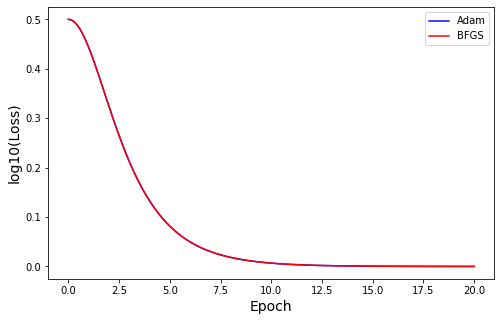

In [6]:
true_u=sol(eom,tplt)
predu=model(tplt)

fig, axes = plt.subplots(1, sharex=True, figsize=(8, 5))
axes.set_ylabel("log10(Loss)", fontsize=14)
axes.set_xlabel("Epoch", fontsize=14)
axes.plot(tplt, true_u, label = f"Adam", color = 'blue')
axes.plot(tplt, predu , label = f"BFGS", color = 'red')
plt.legend()